# **Setting & Introduction**

## **1. Github 연동**

In [1]:
""" github 연동 """
# !git clone https://github.com/ku-sungsukim/2024-LGElec-Day19.git ### colab 사용 시

' github 연동 '

## **2. About Jupyter Notebook**

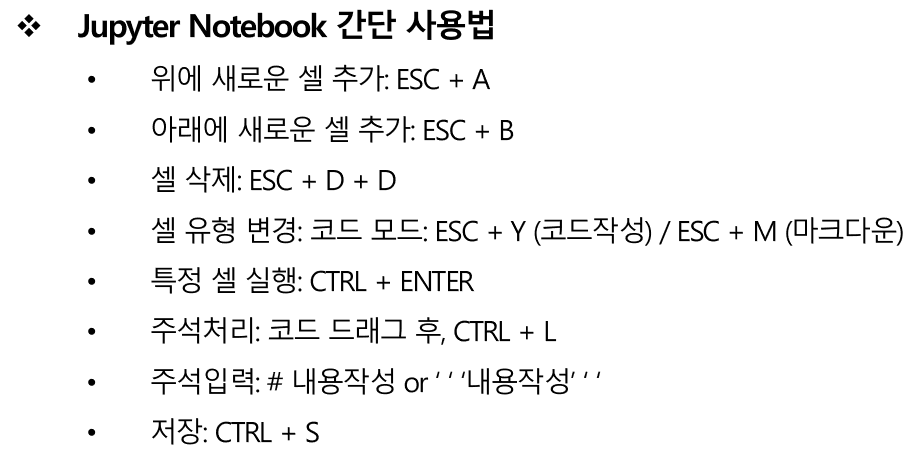

In [2]:
""" 설명 장표 불러오기 """
from IPython.display import Image
Image('image/1-Introduction2.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day19/image/1-Introduction2.PNG') ### colab 사용 시

## **[Self-supervised Learning 실습 목차]**
 ### **(1) Pretext Task** 
 
 - AutoEncoder

 - ***Denoising AutoEncoder √***

 ### **(2) Contrastive Learning** 
 
 - SimCLR

 - SupCon

 ### **(3) Non-Contrastive Learning** 
 
 - BYOL

## **[Denoising AutoEncoder 목차]**
 - DataLoader, Model Architecture, Trainer 정의

 - DenoisingAutoEncoder 사전학습 (Pretraining Task)

 - DenoisingAutoEncoder 미세조정 (Downstream Task)

 - 실험결과 비교

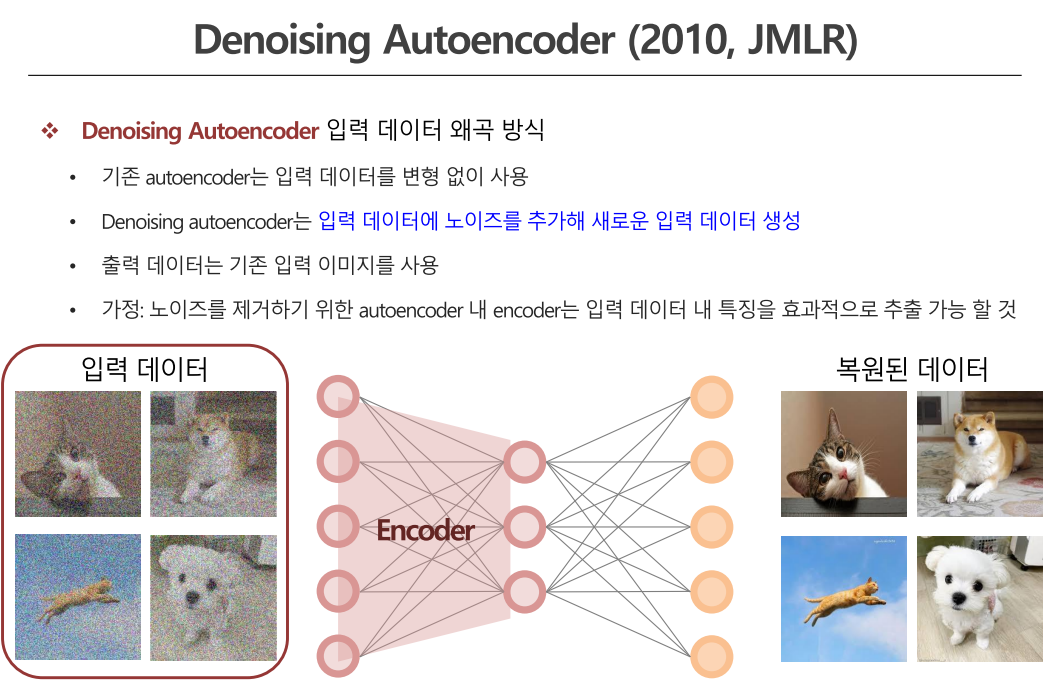

In [3]:
""" 설명 장표 불러오기 """
Image('image/6-DenoisingAutoEncoder.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day19/image/6-DenoisingAutoEncoder.PNG') ### colab 사용 시

## **0. 모델링 환경 설정**

#### **0-1. 필요 패키지 불러오기**

In [4]:
""" 모델링에 필요한 패키지 불러오기 """


""" 기본 환경설정 및 행렬연산 관련된 패키지 """
import os 
import random 
import numpy as np 


""" 모델링 및 학습 관련된 패키지 """
import torch
import torch.nn as nn


""" 데이터 전처리 관련 패키지 """
from torch.utils.data import Dataset, DataLoader, Subset 
from torchvision.transforms import transforms
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split


""" 데이터 시각화 패키지 """
import matplotlib.pyplot as plt
plt.set_cmap('cividis')


""" 경고 숨기기 """
import warnings
warnings.filterwarnings(action='ignore')

c:\Users\DMQA\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

#### **0-2. 랜덤성 통제**

In [5]:
""" random, numpy, torch 패키지에 존재하는 Random성 통제 """
 
"""
 - seed 활용
 - https://hoya012.github.io/blog/reproducible_pytorch/
"""

random_seed = 2024

### random 패키지
random.seed(random_seed)

### numpy 패키지
np.random.seed(random_seed)

### torch 패키지
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) ### multi-GPU 사용시 통제 필요
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **1. DataLoader / Model Architecture / Trainer 정의**

#### **1-1. DataLoader 정의**

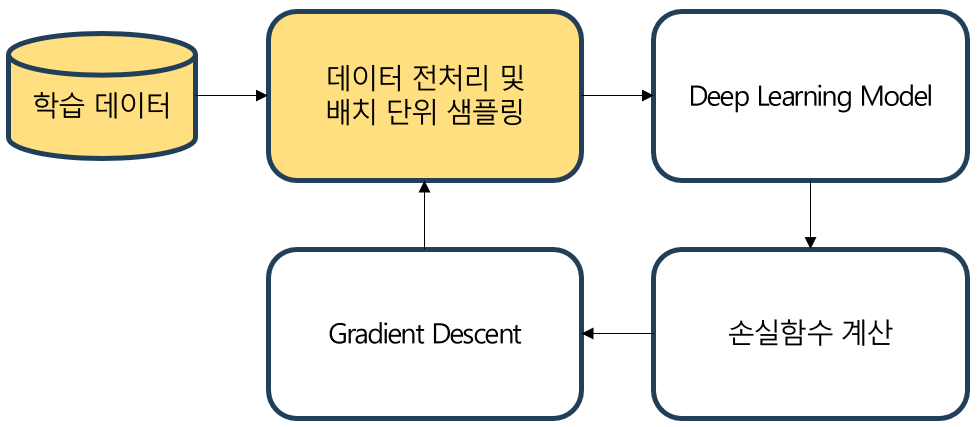

In [6]:
""" 설명 장표 불러오기 """
Image('image/4-TrainingPhase1.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day19/image/4-TrainingPhase1.PNG') ### colab 사용 시

 - **실습 데이터셋: FashionMNIST (의류 이미지 데이터셋)**
 
   (1) 전체 데이터 개수: 70,000개 (60,000개 학습용 / 10,000개 평가용)
     
    - Class 10개: T-shirt / Trouser / Pullover / Dress / Coat / Sandal / Shirt / Sneaker / Bag / Ankle Boot

   (2) Pretraining Task: 60,000개
   
   (3) Downstream Task: 10,000개 (Train: 8,000개 / Test: 2,000개)
   
    - Validation은 별도로 구분하지 않음

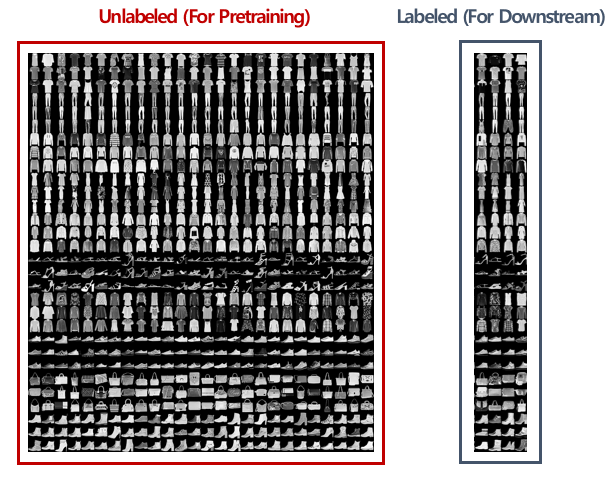

In [7]:
""" 설명 장표 불러오기 """
Image('image/3-FashionMNIST2.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day19/image/3-FashionMNIST2.PNG') ### colab 사용 시

In [8]:
""" 데이터셋 함수 정의 """
class FashionMNISTDataset(Dataset):
    
    ### 데이터셋 경로 정의
    def __init__(self, data_dir:str):
        self.data_dir = data_dir
        os.makedirs(data_dir, exist_ok=True)

    ### Pretraining Task Dataset 불러오기
    def get_pretrain_dataset(self):
        pretrain_dataset = datasets.FashionMNIST(self.data_dir,
                                            train=True, ### True: 60,000개 데이터 불러오기 / False: 10,000개 데이터 불러오기
                                            transform=transforms.ToTensor(), ### jpg --> torch.tensor 변경
                                            download=True)
        return pretrain_dataset
    
    ### Downstream Task Dataset 불러오기
    def get_dataset(self, mode:str='train'):
        downstream_dataset = datasets.FashionMNIST(self.data_dir,
                                             train=False, ### True: 60,000개 데이터 불러오기 / False: 10,000개 데이터 불러오기
                                             transform=transforms.ToTensor(), ### jpg --> torch.tensor 변경
                                             download=True)
        train_idx, test_idx = train_test_split(list(range(len(downstream_dataset))), test_size=0.2, random_state=42)

        if mode == 'train': ### 학습용 데이터 선별: 10,000개 중 8,000개
            train_dataset = Subset(downstream_dataset, train_idx)  
            return train_dataset
        
        elif mode == 'test': ### 평가용 데이터 선별: 10,000개 중 8,000개
            test_dataset = Subset(downstream_dataset, test_idx)   
            return test_dataset

#### **1-2. Model Architecture 정의**

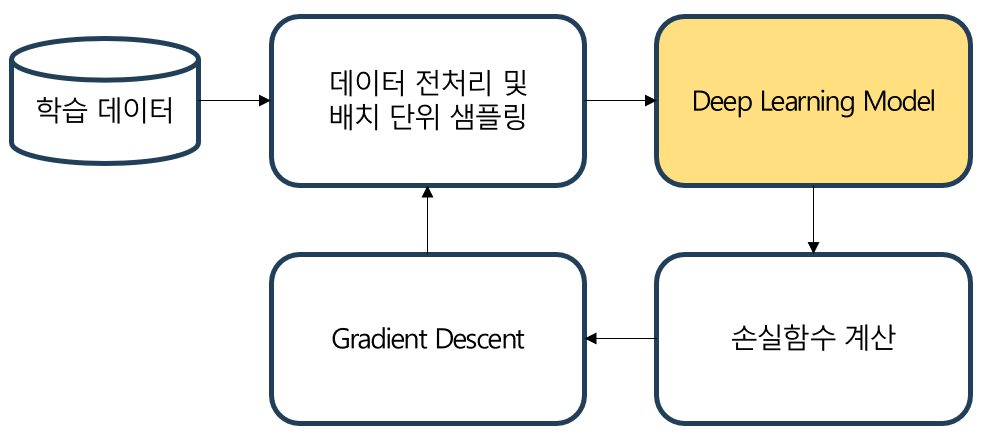

In [9]:
""" 설명 장표 불러오기 """
Image('image/4-TrainingPhase2.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day19/image/4-TrainingPhase2.PNG') ### colab 사용 시

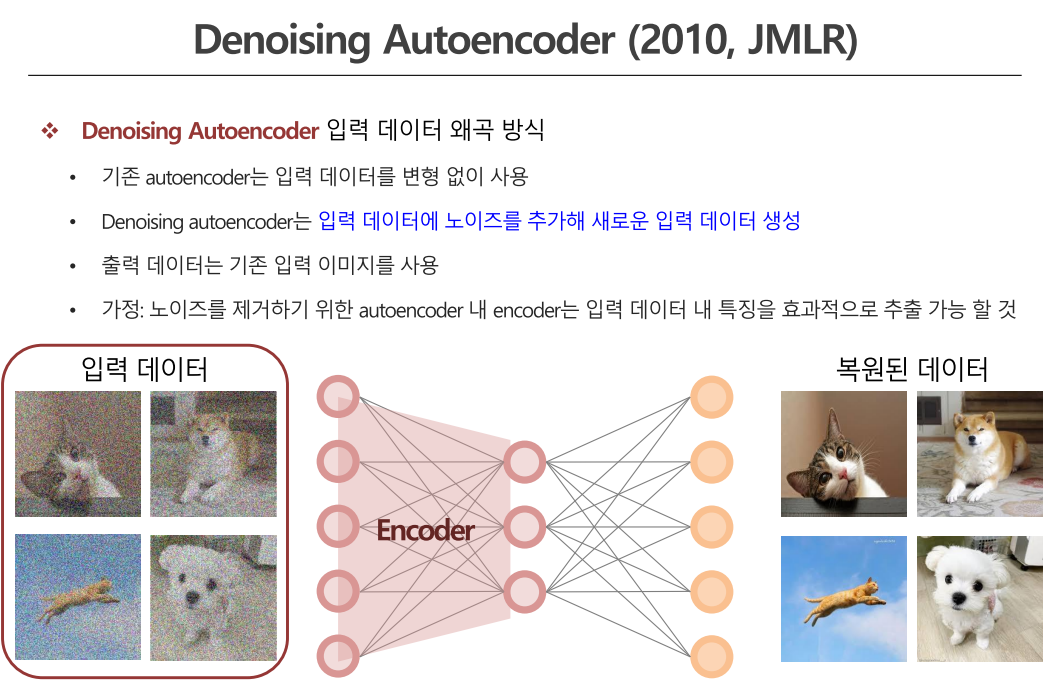

In [10]:
""" 설명 장표 불러오기 """
Image('image/6-DenoisingAutoEncoder.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day19/image/6-DenoisingAutoEncoder.PNG') ### colab 사용 시

In [11]:
""" 원본 이미지에 Noise를 추가하는 함수 """
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

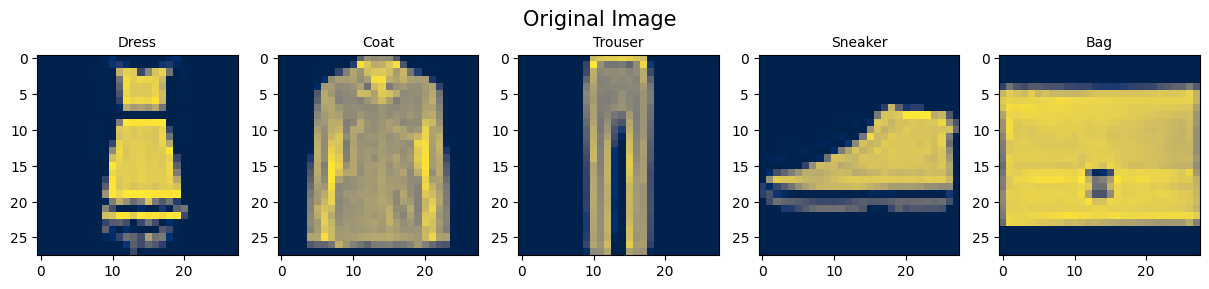

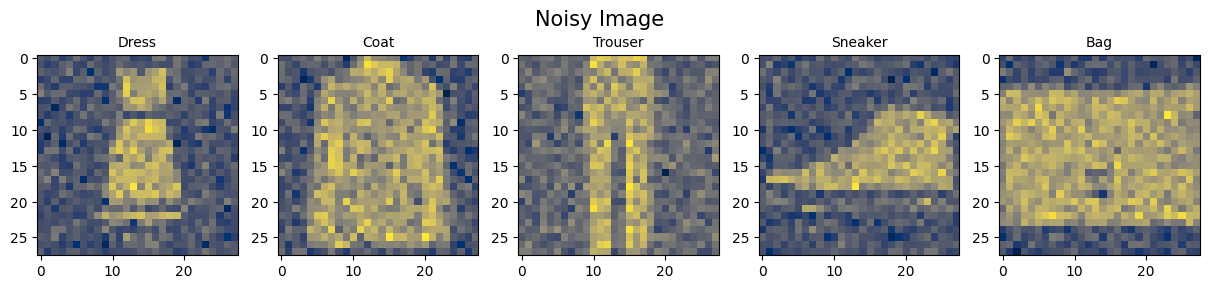

In [12]:
""" Noise가 추가된 이미지 형태 확인 """
### 경로 설정
data_dir = 'data/' ### 로컬 사용 시
# data_dir = '/content/2024-LGElec-Day19/data/' ### colab 사용 시

### 데이터셋 정의
dataset = FashionMNISTDataset(data_dir)
data = dataset.get_dataset()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']  # 총 10개의 classes

### Train 데이터에서 일부 데이터 불러오기
train_loader = DataLoader(
        dataset=data,
        batch_size=5,
        shuffle=True,
        num_workers=0,
        drop_last=False)
images, labels = next(iter(train_loader))

### 원본 이미지
fig = plt.figure(figsize=(15, 3))
for i, img, label in zip(range(5), images, labels):
    numpy_img = np.transpose(img.numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=10)
plt.suptitle("Original Image", fontsize=15)
plt.show()

### Noise가 추가된 이미지
fig = plt.figure(figsize=(15, 3))
for i, img, label in zip(range(5), add_noise(images), labels):
    numpy_img = np.transpose(img.numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=10)
plt.suptitle("Noisy Image", fontsize=15)
plt.show()

In [13]:
""" AutoEncoder 모델 정의 """
class Autoencoder(nn.Module):

    ### 모델 구조 정의
    def __init__(self):
        super(Autoencoder, self).__init__()

        ### Encoder 정의
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), ### 이미지를 압축
        )

        ### Decoder 정의
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), ### 원본 이미지 크기로 복원
            nn.Sigmoid(), 
        )

    ### 실제 데이터가 모델을 통과하는 과정
    def forward(self, x):
        en_out = self.encoder(x)
        de_out = self.decoder(en_out)
        return de_out

## **2. DenoisingAutoEndoer 사전학습 (Pretraining Task)**
 - Pretraining Task 학습 알고리즘 정의
 
 - Pretraining Task 학습 수행

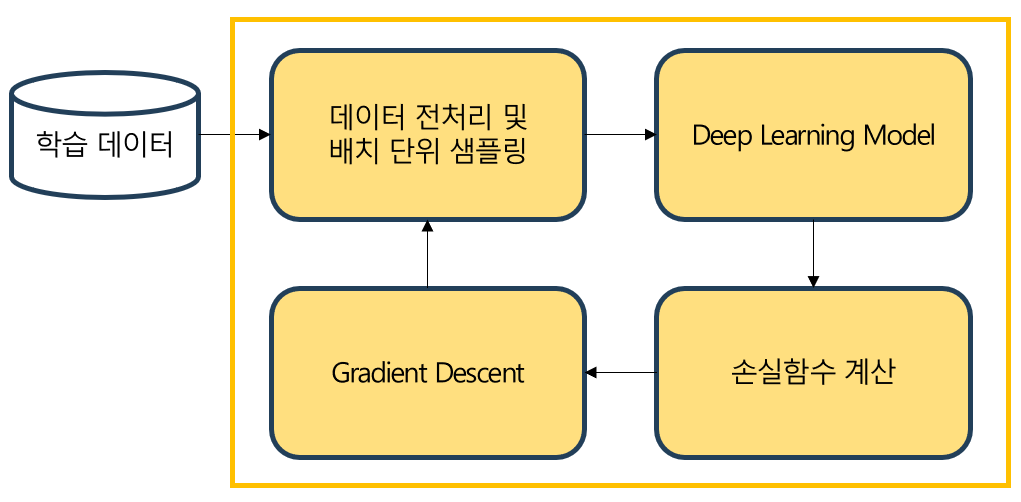

In [14]:
""" 설명 장표 불러오기 """
Image('image/4-TrainingPhase3.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day19/image/4-TrainingPhase3.PNG') ### colab 사용 시

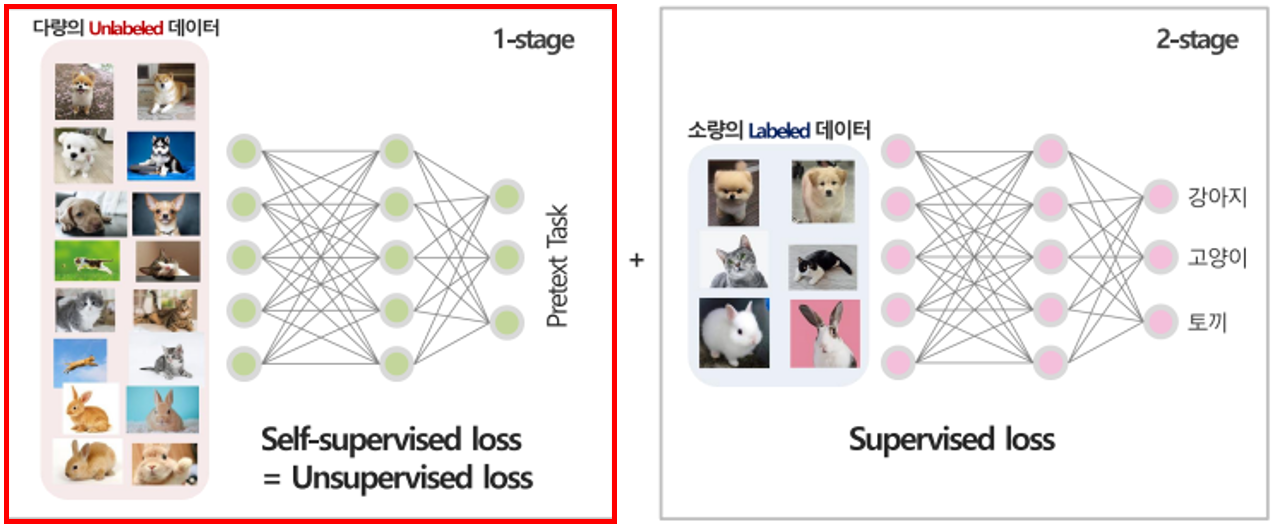

In [15]:
""" 설명 장표 불러오기 """
Image('image/2-SelfsupervisedLearning2.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day19/image/2-SelfsupervisedLearning2.PNG') ### colab 사용 시

In [16]:
""" 1. Pretraining Task 학습 알고리즘 정의 """
class Denoising_AE_Trainer(object):

    ### 학습에 필요한 값들 초기화
    def __init__(self, device, model, **kwargs):
        self.device = device
        self.model = model.to(device)
        self.criterion = nn.MSELoss()
        self.__dict__.update(kwargs)

    ### Pretraining Task 학습 알고리즘
    def pretrain(self, train_loader):
        # make checkpoint directory
        os.makedirs(self.ckpt_dir, exist_ok=True)
        
        for epoch in range(self.epochs+1):
            running_loss, running_total = 0.0, 0
            for images, _ in train_loader:

                ### 데이터 불러온 후, Noise 추가
                images = add_noise(images.view(-1, 28*28)).to(self.device)

                ### DenoisingAutoEncoder Task: 이미지 복원 수행
                outputs = self.model(images)

                ### 모델 학습
                loss = self.criterion(outputs, images)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                ### Iteration 단위(Batch) Loss 산출
                running_loss += loss.item() * images.size(0)
                running_total += images.size(0)

            ### Epoch 단위(전체 학습데이터) Loss 산출
            epoch_loss = running_loss / running_total

            ### Log
            if epoch == 0 or (epoch + 1) % 5 == 0:
                print('Epoch: {} Loss: {:.4f}'.format(epoch+1, epoch_loss))

        ### 마지막 Epoch 모델 저장
        torch.save(self.model.encoder.state_dict(), os.path.join(self.ckpt_dir, 'pretrained_denoised_ae.pt'))

        return self.model

In [17]:
""" 2. Pretraining Task 학습 수행 """
def main(device, configs:dict):

    ### 데이터셋 정의
    dataset = FashionMNISTDataset(data_dir=configs['data_dir']) 
    train_dataset = dataset.get_pretrain_dataset()
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=True)
    
    ### Model Architecture 정의
    model = Autoencoder()

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])

    ### Pretraining Task 학습 알고리즘 정의
    trainer = Denoising_AE_Trainer(device=device, 
                                    model=model, 
                                    optimizer=optimizer,
                                    batch_size = configs['batch_size'],
                                    epochs = configs['epochs'],
                                    ckpt_dir = configs['ckpt_dir']
                                    )
    
    ### Pretraining Task 학습 수행
    pretrained_model = trainer.pretrain(train_loader=train_loader)

    return pretrained_model

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    configs = {'data_dir': 'data/',                          ### colab 사용 시: /content/2024-LGElec-Day19/data/
               'ckpt_dir': 'ckpt_dir/Denoising_AutoEncoder/', ### colab 사용 시: /content/2024-LGElec-Day19/ckpt_dir/Denoising_AutoEncoder/
               'batch_size': 256, 'epochs': 40,
               'learning_rate': 1e-3, 'weight_decay':0, 'num_worker': 0}
    
    pretrained_model_denosing = main(device, configs)

Epoch: 1 Loss: 0.1085
Epoch: 5 Loss: 0.0668
Epoch: 10 Loss: 0.0651
Epoch: 15 Loss: 0.0640
Epoch: 20 Loss: 0.0633
Epoch: 25 Loss: 0.0628
Epoch: 30 Loss: 0.0625
Epoch: 35 Loss: 0.0622
Epoch: 40 Loss: 0.0619


## **3. DenoisingAutoEndoer 미세조정 (Downstream Task)**

- 평가지표 정의

- 미세조정 알고리즘 정의

- 미세조정 수행

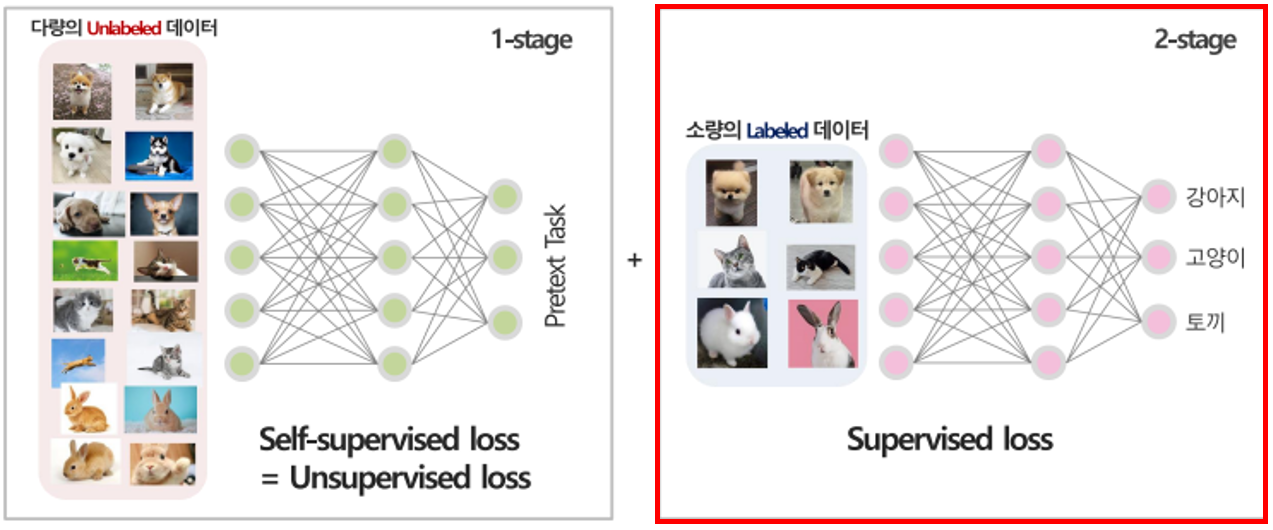

In [19]:
""" 설명 장표 불러오기 """
Image('image/2-SelfsupervisedLearning3.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day19/image/2-SelfsupervisedLearning3.PNG') ### colab 사용 시

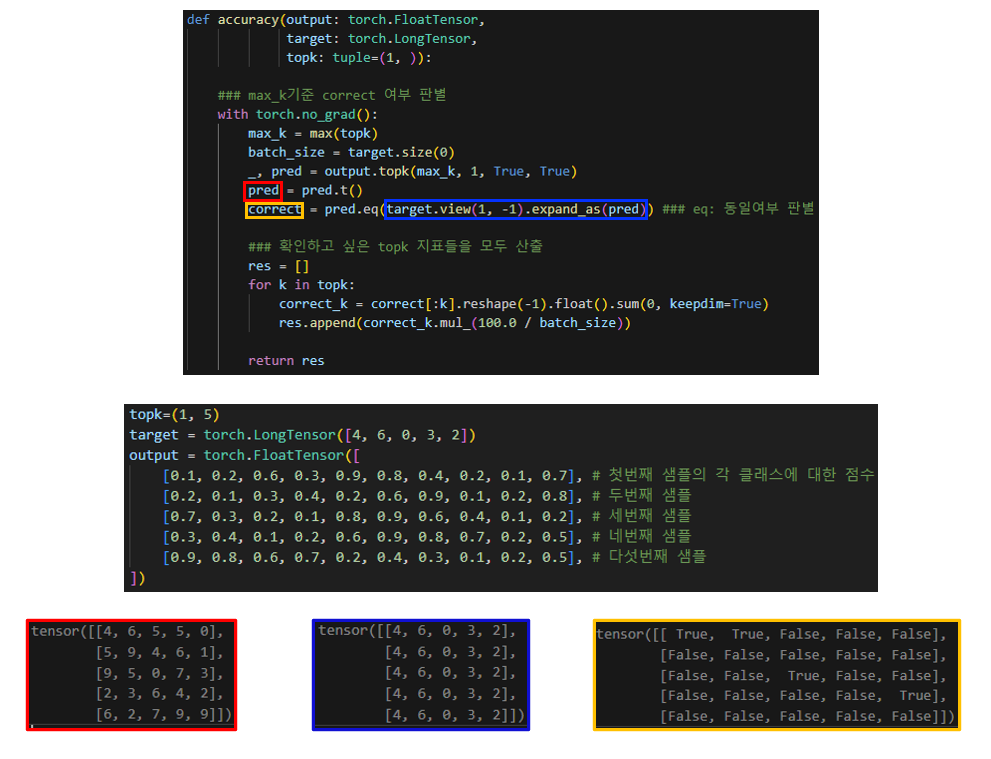

In [20]:
""" 설명 장표 불러오기 """
Image('image/14-Metric1.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day19/image/14-Metric1.PNG') ### colab 사용 시

In [21]:
""" 1. 평가지표 정의 """

"""
Top1 Accuracy: 모델의 Top1 예측 결과가 실제 Label과 동일 --> Correct
Top5 Accuracy: 모델의 Top5 예측 결과 내에 실제 Label의 포함 --> Correct
"""

def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    
    ### max_k기준 correct 여부 판별
    with torch.no_grad():
        max_k = max(topk) 
        batch_size = target.size(0) 
        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)) ### eq: 동일여부 판별

        ### 확인하고 싶은 topk 지표들을 모두 산출 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res

In [22]:
""" 2. 미세조정 (Downstream Task) 학습 알고리즘 정의 """
class Downstream(object):

    ### 학습에 필요한 값들 초기화
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device
        self.encoder = encoder.to(device)
        self.classifier = classifier.to(device)
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    ### Downstream Task 학습 알고리즘
    def train_test(self, train_loader, test_loader):

        for epoch in range(self.epochs):

            ### train 모드
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.view(-1, 28*28).to(self.device)
                targets = targets.to(self.device)
                
                ### 사전학습된 Encoder에 데이터 통과
                if self.downstream: ### Encoder Weight(사전학습된)를 학습하지 않음
                    with torch.no_grad():
                        features = self.encoder(images)
                        features = features.view(features.size(0), -1)  
                else: ### Encoder Weight를 함께 학습
                    features = self.encoder(images)
                    features = features.view(features.size(0), -1)  

                ### Classifier에 통과
                logits = self.classifier(features)
                loss = self.criterion(logits, targets)

                ### 모델 학습
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                ### Iteration 단위(Batch) 평가 지표 산출
                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss
            
            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)

            ### Test 모드
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.view(-1, 28*28).to(self.device)
                targets = targets.to(self.device)

                ### 데이터를 모델(Encoder + Classifier)에 통과 
                with torch.no_grad():
                    features = self.encoder(images)
                    features = features.view(features.size(0), -1)  
                    logits = self.classifier(features)

                ### Iteration 단위(Batch) 평가 지표 산출
                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)

            ### Log
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {round(train_loss.item(), 4)} \n'
                  f'Top1 Train Accuracy: {round(top1_train_acc.item(), 2)} \n'
                  f'Top1 Test Accuracy: {round(top1_test_acc.item(), 2)} \n'
                  f'Top5 Test Accuracy: {round(top5_test_acc.item(), 2)} \n')
        
        return self.encoder, self.classifier

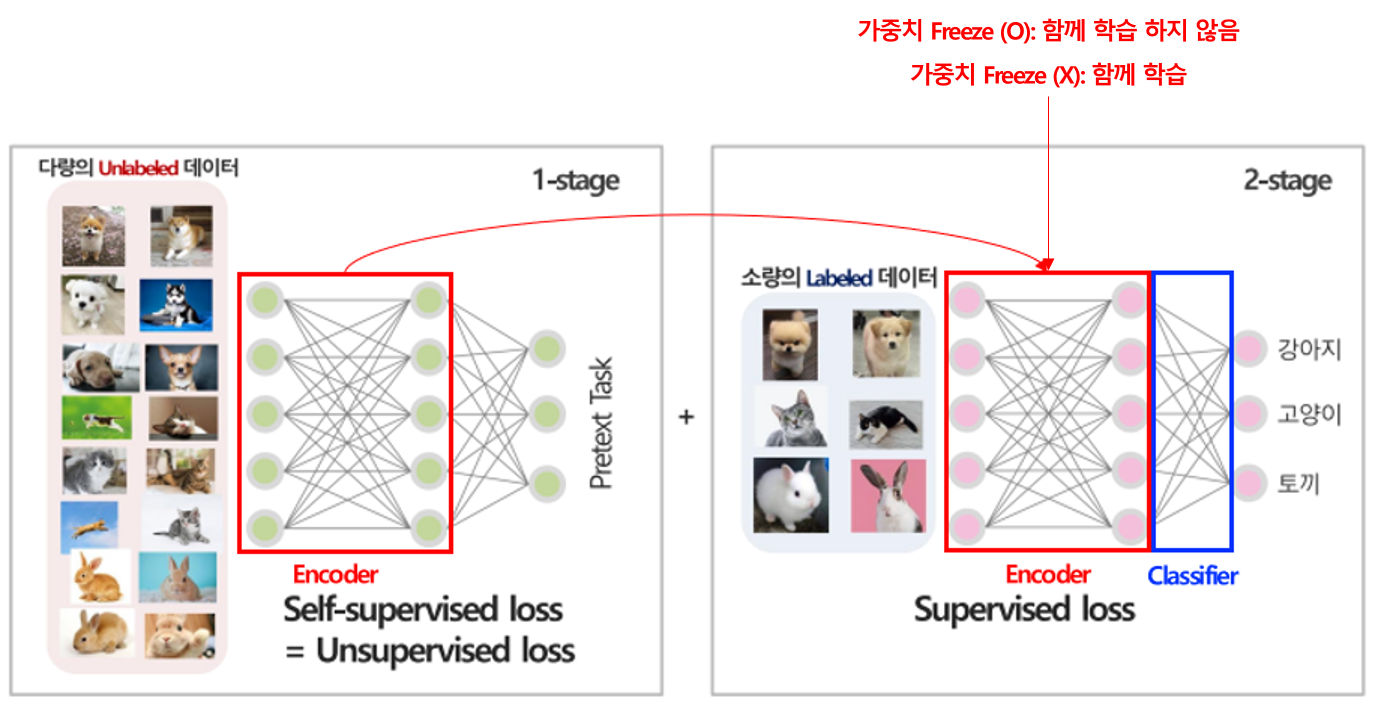

In [23]:
""" 설명 장표 불러오기 """
Image('image/2-SelfsupervisedLearning4.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day19/image/2-SelfsupervisedLearning4.PNG') ### colab 사용 시

In [24]:
""" 3. 미세조정 (Downstream Task) 수행 - Encoder Freeze (O) """
def main(device, configs: dict):
    
    ### Train 및 Test 데이터셋 정의
    dataset = FashionMNISTDataset(data_dir=configs['data_dir'])
    
    train_dataset = dataset.get_dataset(mode='train')
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = Autoencoder().encoder
    encoder.load_state_dict(torch.load(os.path.join(configs['ckpt_dir'], 'pretrained_denoised_ae.pt')))
    print("All keys matched successfully")
    
    classifier = nn.Sequential(
        nn.Linear(3, 32),
        nn.ReLU(),
        nn.Linear(32, configs['num_class'])
    )

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Downstream Task 학습 알고리즘 정의
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': 'data/', ### colab 사용 시: /content/2024-LGElec-Day19/data/
               'ckpt_dir':'ckpt_dir/Denoising_AutoEncoder/', ### colab 사용 시: /content/2024-LGElec-Day19/ckpt_dir/Denoising_AutoEncoder/
               'downstream': True, 'batch_size': 256, 'epochs': 10, 
               'learning_rate': 1e-3, 'weight_decay':0,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

All keys matched successfully
Epoch: 1 
Loss: 4.9534 
Top1 Train Accuracy: 13.27 
Top1 Test Accuracy: 14.71 
Top5 Test Accuracy: 64.11 

Epoch: 2 
Loss: 2.0967 
Top1 Train Accuracy: 23.94 
Top1 Test Accuracy: 36.91 
Top5 Test Accuracy: 85.51 

Epoch: 3 
Loss: 1.5362 
Top1 Train Accuracy: 48.22 
Top1 Test Accuracy: 51.19 
Top5 Test Accuracy: 98.07 

Epoch: 4 
Loss: 1.3194 
Top1 Train Accuracy: 55.47 
Top1 Test Accuracy: 55.83 
Top5 Test Accuracy: 98.85 

Epoch: 5 
Loss: 1.195 
Top1 Train Accuracy: 58.3 
Top1 Test Accuracy: 57.66 
Top5 Test Accuracy: 99.0 

Epoch: 6 
Loss: 1.1135 
Top1 Train Accuracy: 60.5 
Top1 Test Accuracy: 59.53 
Top5 Test Accuracy: 99.0 

Epoch: 7 
Loss: 1.0635 
Top1 Train Accuracy: 62.44 
Top1 Test Accuracy: 60.27 
Top5 Test Accuracy: 99.0 

Epoch: 8 
Loss: 1.0247 
Top1 Train Accuracy: 62.94 
Top1 Test Accuracy: 62.05 
Top5 Test Accuracy: 99.0 

Epoch: 9 
Loss: 0.996 
Top1 Train Accuracy: 63.64 
Top1 Test Accuracy: 63.23 
Top5 Test Accuracy: 99.0 

Epoch: 10 
Loss:

In [25]:
""" 3. 미세조정 (Downstream Task) 수행 - Encoder Freeze (X) """
def main(device, configs: dict):
    
    ### Train 및 Test 데이터셋 정의
    dataset = FashionMNISTDataset(data_dir=configs['data_dir'])
    
    train_dataset = dataset.get_dataset(mode='train')
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = Autoencoder().encoder
    encoder.load_state_dict(torch.load(os.path.join(configs['ckpt_dir'], 'pretrained_denoised_ae.pt'))) ### 사전학습된 Weight 불러오기
    print("All keys matched successfully")
    
    classifier = nn.Sequential(
        nn.Linear(3, 32),
        nn.ReLU(),
        nn.Linear(32, configs['num_class'])
    )

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Pretraining Task 학습 알고리즘 정의
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': 'data/', ### colab 사용 시: /content/2024-LGElec-Day19/data/
               'ckpt_dir':'ckpt_dir/Denoising_AutoEncoder/', ### colab 사용 시: /content/2024-LGElec-Day19/ckpt_dir/Denoising_AutoEncoder/
               'downstream': False, 'batch_size': 256, 'epochs': 10, 
               'learning_rate': 1e-3, 'weight_decay':0,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

All keys matched successfully
Epoch: 1 
Loss: 3.8976 
Top1 Train Accuracy: 21.5 
Top1 Test Accuracy: 21.69 
Top5 Test Accuracy: 85.91 

Epoch: 2 
Loss: 1.6463 
Top1 Train Accuracy: 37.38 
Top1 Test Accuracy: 45.9 
Top5 Test Accuracy: 96.37 

Epoch: 3 
Loss: 1.3794 
Top1 Train Accuracy: 51.79 
Top1 Test Accuracy: 56.72 
Top5 Test Accuracy: 98.05 

Epoch: 4 
Loss: 1.2349 
Top1 Train Accuracy: 59.53 
Top1 Test Accuracy: 62.34 
Top5 Test Accuracy: 98.1 

Epoch: 5 
Loss: 1.1263 
Top1 Train Accuracy: 62.57 
Top1 Test Accuracy: 62.06 
Top5 Test Accuracy: 98.85 

Epoch: 6 
Loss: 1.0466 
Top1 Train Accuracy: 64.99 
Top1 Test Accuracy: 63.74 
Top5 Test Accuracy: 98.79 

Epoch: 7 
Loss: 0.9922 
Top1 Train Accuracy: 65.94 
Top1 Test Accuracy: 64.83 
Top5 Test Accuracy: 98.7 

Epoch: 8 
Loss: 0.9579 
Top1 Train Accuracy: 66.24 
Top1 Test Accuracy: 67.18 
Top5 Test Accuracy: 98.85 

Epoch: 9 
Loss: 0.9263 
Top1 Train Accuracy: 67.04 
Top1 Test Accuracy: 66.52 
Top5 Test Accuracy: 98.84 

Epoch: 10 


#### **최종 성능 비교**

|   | Supervised Learning | AutoEncoder (Freeze O) | DenoisingAutoEncoder (Freeze O) | AutoEncoder (Freeze X) | DenoisingAutoEncoder (Freeze X) |
|---| ------------------- | ---------------------- | ------------------------------- | ---------------------- | ------------------------------- |
|Top 1 Train ACC| 10.38 | 66.28 | 64.78 | 66.87 | 67.10 |
|Top 1 Test ACC| 8.34 | 65.38 | 64.27 | 65.11 | 66.59 |
|Top 5 Test ACC| 49.41 | 98.94 | 98.95 | 98.89 | 98.90 |